In [7]:
import timm
import torch
import wandb
import fastai
import dill
import numpy as np
from fastai.callback.wandb import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.text.core import RegexLabeller
from fastai.vision.utils import get_image_files
from fastai.data.block import DataBlock
from fastai.data.core import *
from fastai.tabular.all import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login, push_to_hub_fastai, from_pretrained_fastai

import pandas as pd
import plotly.express as px

# Ball detection

In [ ]:
# import model again to test
learn = load_learner(Path(r"F:\ball_classifier\Models\ball_classifier.pkl"))
# print(learn.dls.vocab) # print all possible classes of model

# import testing data and predict class using model
dataset_path=r"F:\\" # path to directory containing images
files = get_image_files(path=dataset_path, recurse=True, folders=('Beetle_classification_deep_data_segmented')) # get files from directory
test_dl = learn.dls.test_dl(files, with_labels=False) # load data as a dataloader
preds = learn.get_preds(dl=test_dl)

# get filenames and their order from how they are ingested into0 classifier
filenames = [os.path.basename(path) for path in list(files)]
filenames_without_ext = [os.path.splitext(filename)[0] for filename in filenames]
preds_probs, preds_class = torch.max(preds[0], axis=1)
preds_class_str_arr = np.where(preds_class == 1, 'non_ball', 'ball')

# create dataframe of classifications
data = {}
data['pred'] = preds_class_str_arr.tolist()
data['segmented_image_name'] = filenames_without_ext
df_pred = pd.DataFrame(data)

# import metadata csv
data_dir = r"F:\Beetle_classification_deep_data_segmented\segmented_images_metadata.csv"
metadata_df = pd.read_csv(data_dir, index_col="Unnamed: 0",low_memory=False)

# merge predictions with metadata csv
metadata_df = pd.merge(metadata_df, df_pred, on = "segmented_image_name", how = "outer")
metadata_df.to_csv(r"F:\Beetle_classification_deep_data_segmented\segmented_images_metadata.csv")

# Outlier detection

In [2]:
# import metadata csv to use for outlier detection 
data_dir = r"F:\Beetle_classification_deep_data_segmented\segmented_images_metadata.csv"
metadata_df = pd.read_csv(data_dir, index_col="Unnamed: 0",low_memory=False)

In [3]:
metadata_df

centroid-0   centroid-1  bbox-0  bbox-1  bbox-2  bbox-3  orientation  \
0       902.268968  2434.645990     669    2159    1176    2680     0.851181   
1      1126.571843   617.557308     951     321    1310     897     1.244527   
2      1278.681092  1165.795350    1053     916    1552    1452    -0.894788   
3      1605.594882  2032.423819    1344    1766    1884    2305     0.817268   
4      1697.276058   749.737463    1543     486    1879    1032    -1.357185   
...            ...          ...     ...     ...     ...     ...          ...   
32459  1204.977287  2932.880730     677    2582    1754    3262     0.209518   
32460  2177.058473  1305.929270    1928     788    2526    1820     1.363932   
32461  2594.744857  2537.921139    2133    2010    2979    3023    -0.988549   
32462  3848.317215  2570.917765    3314    2274    4412    3003    -0.173802   
32463  3931.868711  1460.536132    3550     910    4241    2014     1.429206   

       axis_major_length  axis_minor_length    area  ...  kmeans_label  \
0             551.446345         208.663148   77526  ...             1   
1             533.552869         184.634309   71691  ...             1   
2             567.996227         196.588315   76511  ...             1   
3             584.804556         204.174837   88073  ...             1   
4             488.424417         172.302348   61679  ...             1   
...                  ...                ...     ...  ...           ...   
32459        1060.008301         363.079292  269539  ...             1   
32460        1015.882306         357.259946  258306  ...             1   
32461        1082.147025         374.123220  286138  ...             1   
32462        1095.605815         395.401014  292272  ...             1   
32463        1102.357278         381.641970  289117  ...             1   

       circle_class  pixel_count  \
0        non_circle        77554   
1        non_circle        71716   
2        non_circle        76520   
3        non_circle        88097   
4        non_circle        61699   
...             ...          ...   
32459       unknown       269628   
32460       unknown       259200   
32461       unknown       286247   
32462       unknown       292323   
32463       unknown       289398   

                                    composite_image_path  \
0      Z:\lab records\Christopher_Marais\Beetle_class...   
1      Z:\lab records\Christopher_Marais\Beetle_class...   
2      Z:\lab records\Christopher_Marais\Beetle_class...   
3      Z:\lab records\Christopher_Marais\Beetle_class...   
4      Z:\lab records\Christopher_Marais\Beetle_class...   
...                                                  ...   
32459  Z:\lab records\Christopher_Marais\Beetle_class...   
32460  Z:\lab records\Christopher_Marais\Beetle_class...   
32461  Z:\lab records\Christopher_Marais\Beetle_class...   
32462  Z:\lab records\Christopher_Marais\Beetle_class...   
32463  Z:\lab records\Christopher_Marais\Beetle_class...   

                       species   vial subset  composite_image_number  \
0      Coccotypes_dactyliperda  16296      1                      52   
1      Coccotypes_dactyliperda  16296      1                      52   
2      Coccotypes_dactyliperda  16296      1                      52   
3      Coccotypes_dactyliperda  16296      1                      52   
4      Coccotypes_dactyliperda  16296      1                      52   
...                        ...    ...    ...                     ...   
32459       Platypus_cylindrus  22849      5                    0065   
32460       Platypus_cylindrus  22849      5                    0065   
32461       Platypus_cylindrus  22849      5                    0065   
32462       Platypus_cylindrus  22849      5                    0065   
32463       Platypus_cylindrus  22849      5                    0065   

                         segmented_image_name    target  
0      Coccotypes_dactyliperda_16296_1_0052_0  non_ball  
1      Coccotypes_dacty

In [4]:
df_od = metadata_df[["segmented_image_name", "area", "species", "target", "pixel_count"]]
df_od = df_od[df_od['target'] == "non_ball"]
df_od

segmented_image_name    area  \
0      Coccotypes_dactyliperda_16296_1_0052_0   77526   
1      Coccotypes_dactyliperda_16296_1_0052_1   71691   
2      Coccotypes_dactyliperda_16296_1_0052_2   76511   
3      Coccotypes_dactyliperda_16296_1_0052_3   88073   
4      Coccotypes_dactyliperda_16296_1_0052_4   61679   
...                                       ...     ...   
32459       Platypus_cylindrus_22849_5_0065_3  269539   
32460       Platypus_cylindrus_22849_5_0065_4  258306   
32461       Platypus_cylindrus_22849_5_0065_5  286138   
32462       Platypus_cylindrus_22849_5_0065_6  292272   
32463       Platypus_cylindrus_22849_5_0065_7  289117   

                       species    target  pixel_count  
0      Coccotypes_dactyliperda  non_ball        77554  
1      Coccotypes_dactyliperda  non_ball        71716  
2      Coccotypes_dactyliperda  non_ball        76520  
3      Coccotypes_dactyliperda  non_ball        88097  
4      Coccotypes_dactyliperda  non_ball        61699  
...                        ...       ...          ...  
32459       Platypus_cylindrus  non_ball       269628  
32460       Platypus_cylindrus  non_ball       259200  
32461       Platypus_cylindrus  non_ball       286247  
32462       Platypus_cylindrus  non_ball       292323  
32463       Platypus_cylindrus  non_ball       289398  

[31126 rows x 5 columns]

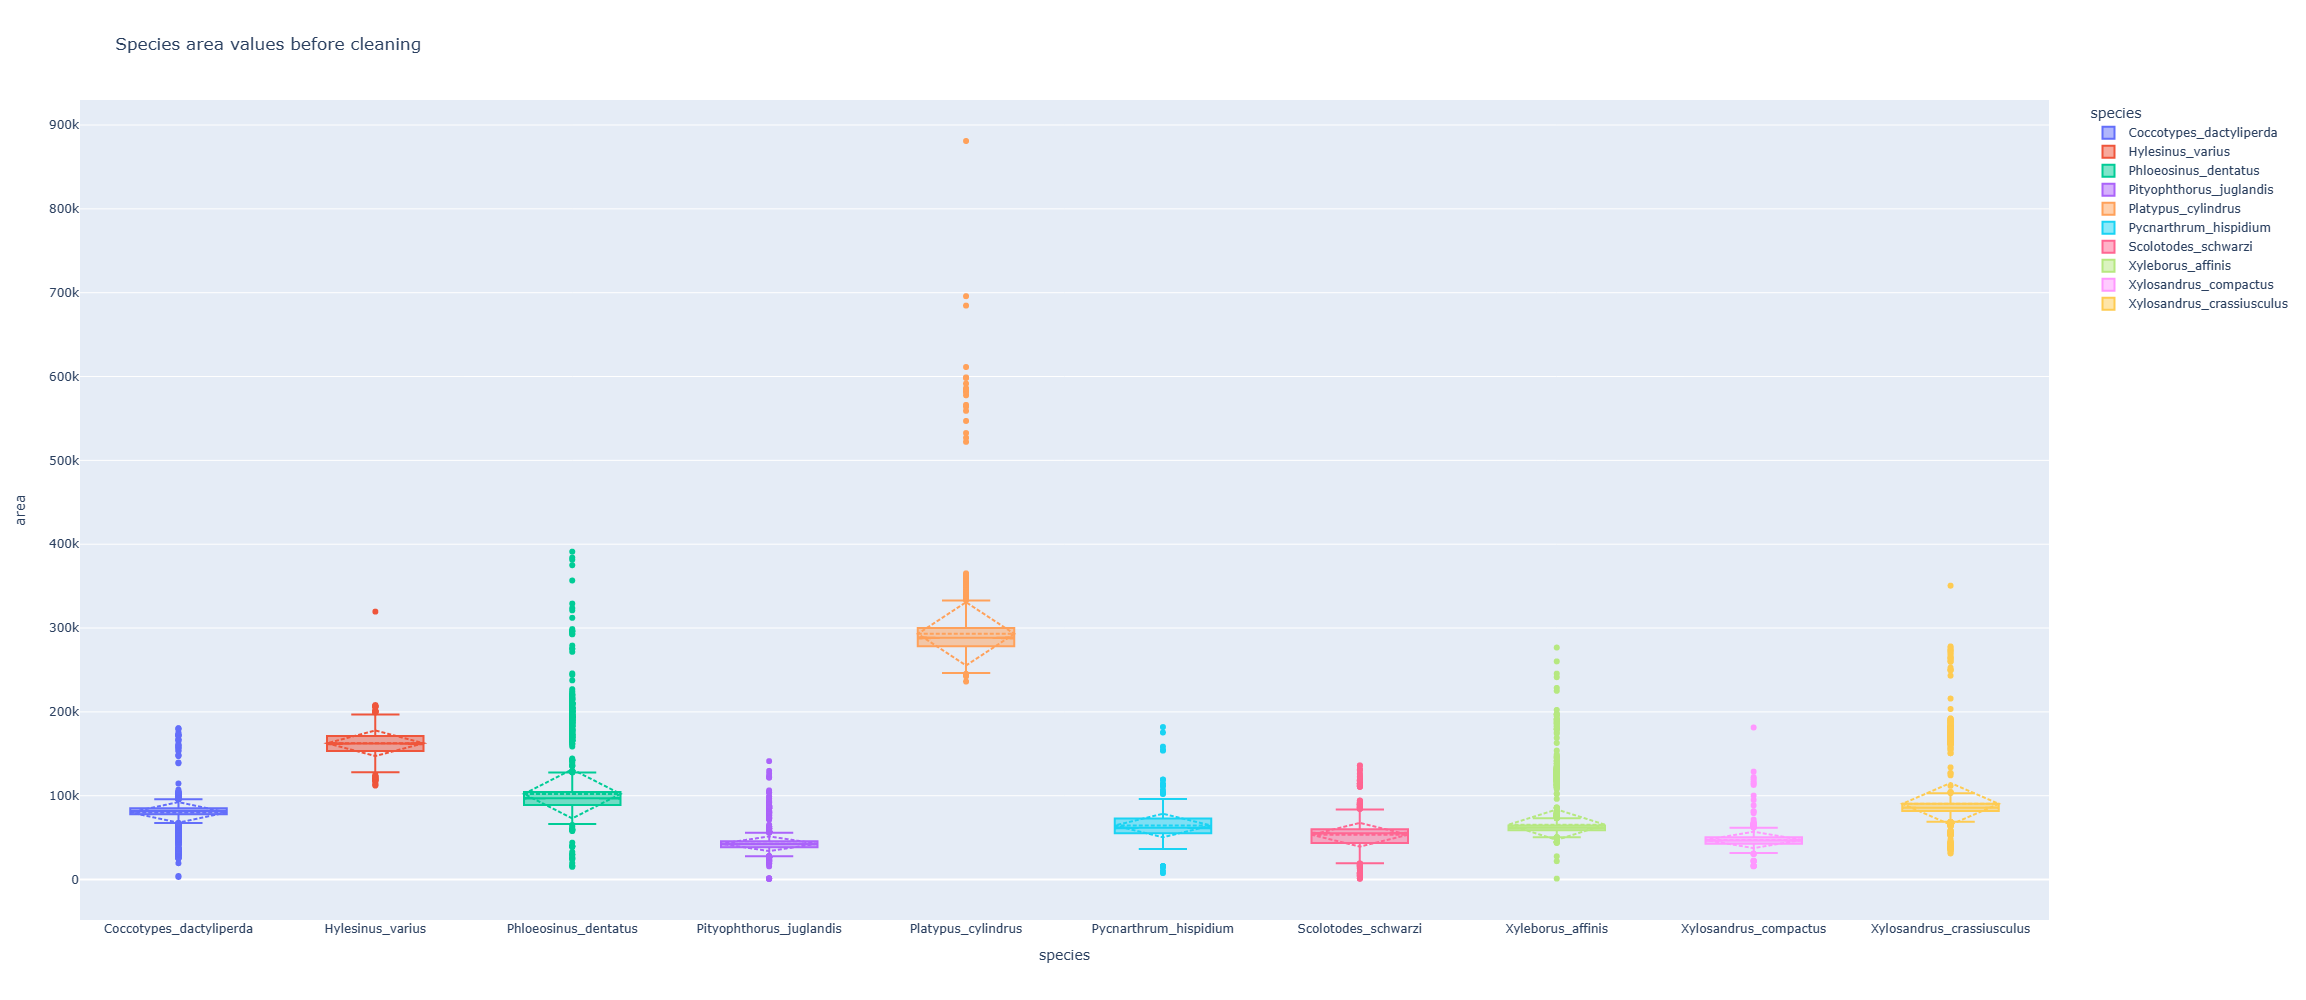

In [6]:
# boxplot of area per species 
fig = px.box(df_od, x="species", y="area", color="species",
             notched=True, # used notched shape
             title="Species area values before cleaning",
             hover_data=["area", "segmented_image_name"])
fig.update_traces(boxmean=True)
fig.update_traces(boxmean="sd")
fig.update_layout(
    # autosize=True, 
    width=2000, 
    height=1000
                 )
fig.show()

In [ ]:
# move all outlier iamges to an outlier folder and sift through them by hand